## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

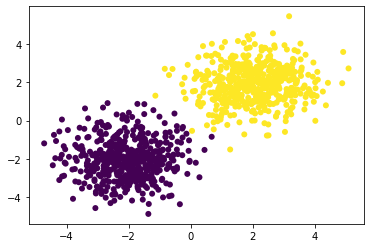

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

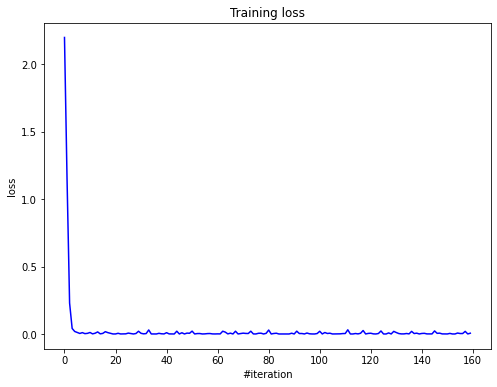

Current loss: 0.005710


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
# import mnist

from mnist.loader import MNIST
mndata = MNIST('./fmnist/FashionMNIST/raw/')
X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()
# X_train, y_train, X_val, y_val, X_test, y_test = mnist.loader.load_dataset()

One-hot encode the labels first.

In [9]:
DIGITS_COUNT = len(set(y_train))
DIGITS_COUNT

10

In [10]:
new_y_train = []
new_y_test = []

for label in y_train:
    temp = np.zeros(DIGITS_COUNT, 'int32')
    temp[label] = 1
    new_y_train.append(temp)
    
for label in y_test:
    temp = np.zeros(DIGITS_COUNT, 'int32')
    temp[label] = 1
    new_y_test.append(temp)
    
y_train = np.array(new_y_train)
y_test = np.array(new_y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [11]:
print(y_train[0])
in_size = len(X_train[0])
out_size = len(y_train[0])

[0 0 0 0 0 0 0 0 0 1]


In [12]:
print(y_train.shape)
print(X_train.shape)

(60000, 10)
(60000, 784)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [13]:
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

def train(net, n_epoch, criterion, X, Y, name, optimizer_config, optimizer_state):
    loss_history = []
    loss_history_per_batch = []
    test_loss_hist = []

    for i in range(n_epoch):
        cur_loss = 0
        cur_ctr = 0
        for x_batch, y_batch in get_batches((X, Y), batch_size):
            net.train()
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
            
            cur_loss += loss
            cur_ctr += 1
            
            loss_history.append(loss)
            
        loss_history_per_batch.append(cur_loss / cur_ctr)
        test_loss, _ = test(net, criterion, x_batch, y_batch, name, optimizer_config, optimizer_state)
        test_loss_hist.append(test_loss)

        print(f'\tCurrent train loss for {name} {i + 1}/{n_epoch} epoch: {cur_loss / cur_ctr}')

    return loss_history, loss_history_per_batch, test_loss_hist

def test(net, criterion, X, Y, name, optimizer_config, optimizer_state):
    net.evaluate()
    predictions = net.forward(X)
    loss = criterion.forward(predictions, Y)
    
    print(f'\tCurrent test loss for {name}: {loss}')
    
    return loss, predictions

def model_generator():
    models_lst = []
    activations_lst = [ReLU, ELU, LeakyReLU, SoftPlus]
    activations_names = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus']
    
    for activation_layer, name in zip(activations_lst, activations_names):
        net = Sequential()
        net.add(Linear(in_size, 4 * in_size))
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(4 * in_size))

        net.add(activation_layer())

        net.add(Linear(4 * in_size, out_size))
        net.add(LogSoftMax())
        
        yield (net, name)
        
def train_several_models(n_epoch, X_train, y_train, X_test, y_test):
    loss_for_all_models = []
    activations_names = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus']
    
    for i, (model, name) in enumerate(model_generator()):
        print(f'Start train model with {name} ({i}/{len(activations_names)})')
        optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
        optimizer_state = {}
        criterion = ClassNLLCriterion()
        start_time = time()
        current_train_loss, current_train_loss_per_batch, current_test_loss = train(model, n_epoch, criterion, X_train, y_train, name, optimizer_config, optimizer_state)
        end_time = time()
#         current_test_loss = test(model, criterion, X_test, y_test, name, optimizer_config, optimizer_state)
        train_time = end_time - start_time
        
        loss_for_all_models.append(
            {
                'name': name,
                'train_loss': current_train_loss,
                'train_loss_per_batch': current_train_loss_per_batch,
                'test_loss': current_test_loss,
                'train_time': train_time,
            }
        )
        print(f'\n\tPrint train time: {train_time}')
    
    return loss_for_all_models

In [14]:
# Looping params
n_epoch = 20
batch_size = 128

In [15]:
losses_with_batchnorm = train_several_models(n_epoch, X_train, y_train, X_test, y_test)

Start train model with ReLU (0/4)
	Current test loss for ReLU: 0.2663707515887468
	Current train loss for ReLU 1/20 epoch: 0.5801731022786877
	Current test loss for ReLU: 0.181295094575362
	Current train loss for ReLU 2/20 epoch: 0.3541139621260232
	Current test loss for ReLU: 0.3573733924753501
	Current train loss for ReLU 3/20 epoch: 0.3115862037525041
	Current test loss for ReLU: 0.2762719271210215
	Current train loss for ReLU 4/20 epoch: 0.2825526131192066
	Current test loss for ReLU: 0.20489966873316642
	Current train loss for ReLU 5/20 epoch: 0.26264132400457035
	Current test loss for ReLU: 0.19920964236014663
	Current train loss for ReLU 6/20 epoch: 0.2451631924159888
	Current test loss for ReLU: 0.22821135381892454
	Current train loss for ReLU 7/20 epoch: 0.22957360178663533
	Current test loss for ReLU: 0.19097324199679155
	Current train loss for ReLU 8/20 epoch: 0.2150347768679542
	Current test loss for ReLU: 0.11053130885149805
	Current train loss for ReLU 9/20 epoch: 0.20407

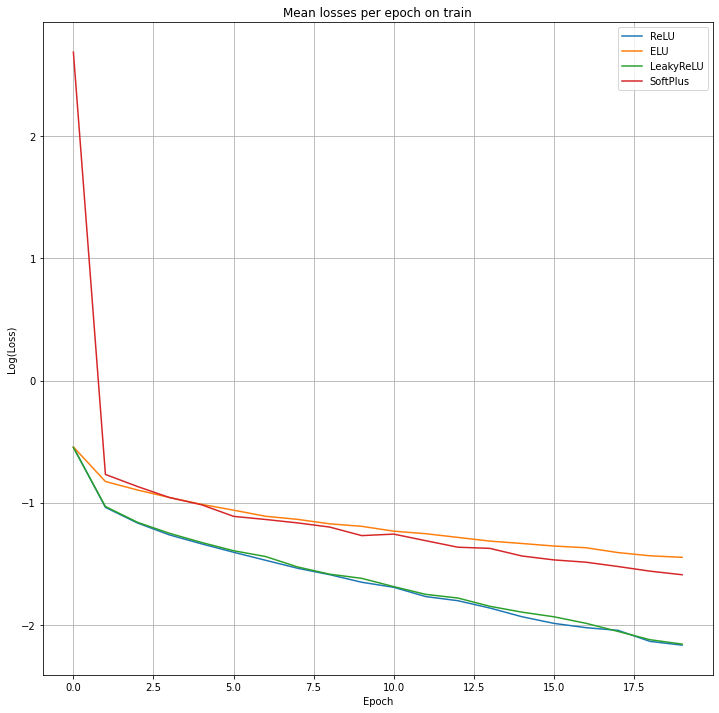

In [16]:
plt.figure(figsize=(12, 12))
for loss_item in losses_with_batchnorm:
    plt.plot(np.log(loss_item['train_loss_per_batch']))
plt.grid()
plt.legend([item['name'] for item in losses_with_batchnorm])
plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
plt.title('Mean losses per epoch on train')
plt.show()

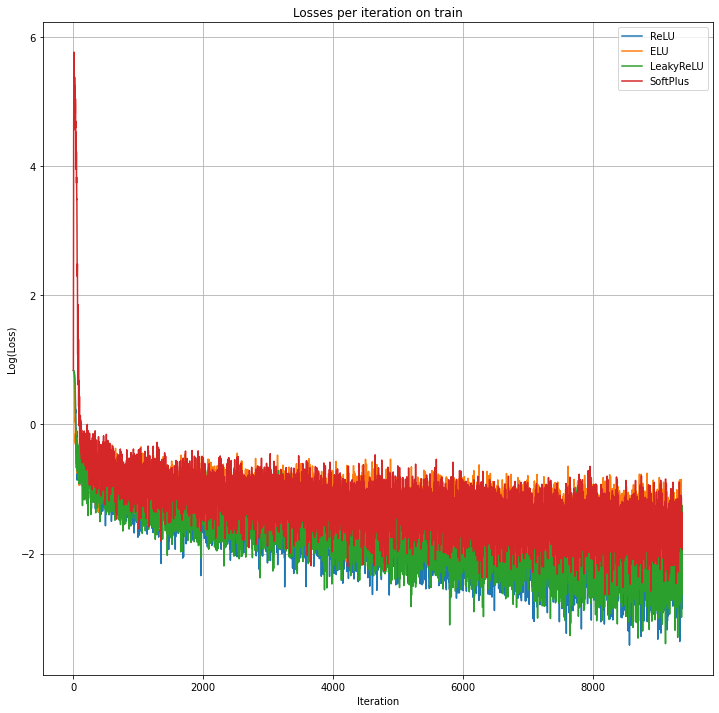

In [17]:
plt.figure(figsize=(12, 12))
for loss_item in losses_with_batchnorm:
    plt.plot(np.log(loss_item['train_loss']))
plt.grid()
plt.legend([item['name'] for item in losses_with_batchnorm])
plt.xlabel('Iteration')
plt.ylabel('Log(Loss)')
plt.title('Losses per iteration on train')
plt.show()

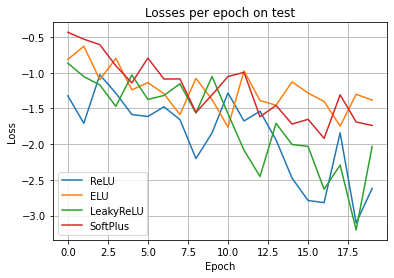

In [18]:
for loss_item in losses_with_batchnorm:
    plt.plot(np.log(loss_item['test_loss']))
plt.grid()
plt.legend([item['name'] for item in losses_with_batchnorm])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses per epoch on test')
plt.show()

In [19]:
# Now without BatchNorm
def model_generator():
    models_lst = []
    activations_lst = [ReLU, ELU, LeakyReLU, SoftPlus]
    activations_names = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus']
    
    for activation_layer, name in zip(activations_lst, activations_names):
        net = Sequential()
        net.add(Linear(in_size, 4 * in_size))
#         net.add(BatchNormalization())
#         net.add(ChannelwiseScaling(4 * in_size))

        net.add(activation_layer())

        net.add(Linear(4 * in_size, out_size))
        net.add(LogSoftMax())
        
        yield (net, name)

In [20]:
losses_without_batchnorm = train_several_models(n_epoch, X_train, y_train, X_test, y_test)

Start train model with ReLU (0/4)
	Current test loss for ReLU: 2.287325874333955
	Current train loss for ReLU 1/20 epoch: 456699.0463917939
	Current test loss for ReLU: 2.3034120554758855
	Current train loss for ReLU 2/20 epoch: 2.308603944631083
	Current test loss for ReLU: 2.296537519710188
	Current train loss for ReLU 3/20 epoch: 2.304491455235745
	Current test loss for ReLU: 2.3098908136912475
	Current train loss for ReLU 4/20 epoch: 2.3046003403577062
	Current test loss for ReLU: 2.3067539280332183
	Current train loss for ReLU 5/20 epoch: 2.3045059956400373
	Current test loss for ReLU: 2.303281822969667
	Current train loss for ReLU 6/20 epoch: 2.304295435042988
	Current test loss for ReLU: 2.298442900507834
	Current train loss for ReLU 7/20 epoch: 2.3042717252896883
	Current test loss for ReLU: 2.3015235500987288
	Current train loss for ReLU 8/20 epoch: 2.3045843942312056
	Current test loss for ReLU: 2.307483438385718
	Current train loss for ReLU 9/20 epoch: 2.3044540269886284
	Cu

<ipython-input-2-2eb8440a775c>:9: RuntimeWarning: overflow encountered in exp
  self.output = np.where(input <= 0, self.alpha * (np.exp(input) - 1), input)


	Current test loss for ELU: 8364521.833732374
	Current train loss for ELU 1/20 epoch: 83812553.4420088
	Current test loss for ELU: 8091599.548069917
	Current train loss for ELU 2/20 epoch: 8590565.986342188
	Current test loss for ELU: 7925697.680524066
	Current train loss for ELU 3/20 epoch: 8000772.96348231
	Current test loss for ELU: 6573838.424215674
	Current train loss for ELU 4/20 epoch: 7411802.49363913
	Current test loss for ELU: 6880213.338431205
	Current train loss for ELU 5/20 epoch: 6823786.7390260035
	Current test loss for ELU: 5913665.206222735
	Current train loss for ELU 6/20 epoch: 6235105.741620285
	Current test loss for ELU: 5184396.383370639
	Current train loss for ELU 7/20 epoch: 5646503.160197011
	Current test loss for ELU: 5221510.238202349
	Current train loss for ELU 8/20 epoch: 5058349.122516186
	Current test loss for ELU: 4277540.117740276
	Current train loss for ELU 9/20 epoch: 4469649.464722655
	Current test loss for ELU: 3723394.646618714
	Current train loss 

/home/aslan/anaconda3/envs/ml_env_clone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-2-e34a824c393d>:7: RuntimeWarning: invalid value encountered in subtract
  self.output = np.subtract(input, input.max(axis=1, keepdims=True))
<ipython-input-2-e34a824c393d>:17: RuntimeWarning: invalid value encountered in subtract
  current_input = np.exp(input - input.max(axis=1, keepdims=True))
<ipython-input-2-448939660819>:10: RuntimeWarning: invalid value encountered in less_equal
  self.output = np.where(input <= 0, self.slope * input, input)
<ipython-input-2-448939660819>:17: RuntimeWarning: invalid value encountered in greater
  current_input = np.where(input > 0, 1, input)
<ipython-input-2-448939660819>:19: RuntimeWarning: invalid value encountered in less
  current_input = np.where(current_input < 0, self.slope, current_input)


	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 1/20 epoch: nan
	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 2/20 epoch: nan
	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 3/20 epoch: nan
	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 4/20 epoch: nan
	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 5/20 epoch: nan
	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 6/20 epoch: nan
	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 7/20 epoch: nan
	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 8/20 epoch: nan
	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 9/20 epoch: nan
	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 10/20 epoch: nan
	Current test loss for LeakyReLU: nan
	Current train loss for LeakyReLU 11/20 epoch: nan
	Current test loss for LeakyRe

<ipython-input-2-f50066533aac>:8: RuntimeWarning: overflow encountered in exp
  self.output = np.log(1 + np.exp(input))
<ipython-input-2-f50066533aac>:15: RuntimeWarning: overflow encountered in exp
  self.gradInput = np.exp(input) / (1 + np.exp(input)) * gradOutput
<ipython-input-2-f50066533aac>:15: RuntimeWarning: invalid value encountered in true_divide
  self.gradInput = np.exp(input) / (1 + np.exp(input)) * gradOutput


	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 1/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 2/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 3/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 4/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 5/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 6/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 7/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 8/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 9/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 10/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train loss for SoftPlus 11/20 epoch: nan
	Current test loss for SoftPlus: nan
	Current train 

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Вывод:** Из результатов выше становится очевидно, что без BatchNorm алгоритм не сходится.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [21]:
net = Sequential()
net.add(Linear(in_size, 512))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(512))
net.add(ReLU())
net.add(Dropout(0.15))
net.add(Linear(512, 512))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(512))
net.add(ReLU())
net.add(Linear(512, out_size))
net.add(LogSoftMax())

n_epoch = 30

optimizer_config = {'learning_rate' : 8e-2, 'momentum': 0.9, 'beta1': 0.1}
optimizer_state = {}
criterion = ClassNLLCriterion()

In [22]:
loss_history, loss_history_per_batch, test_loss_hist = train(net, n_epoch, criterion, X_train, y_train, 'ReLU', optimizer_config, optimizer_state)

	Current test loss for ReLU: 0.3716094407394463
	Current train loss for ReLU 1/30 epoch: 0.6528209115512645
	Current test loss for ReLU: 0.3276847276760331
	Current train loss for ReLU 2/30 epoch: 0.3677382502351913
	Current test loss for ReLU: 0.3615246699907682
	Current train loss for ReLU 3/30 epoch: 0.3297125274746267
	Current test loss for ReLU: 0.24918578592704158
	Current train loss for ReLU 4/30 epoch: 0.3040993828512177
	Current test loss for ReLU: 0.21756296623615337
	Current train loss for ReLU 5/30 epoch: 0.28718350933213516
	Current test loss for ReLU: 0.2067875378432725
	Current train loss for ReLU 6/30 epoch: 0.2694622874965146
	Current test loss for ReLU: 0.1966079378979335
	Current train loss for ReLU 7/30 epoch: 0.2544338146327472
	Current test loss for ReLU: 0.1622991415278982
	Current train loss for ReLU 8/30 epoch: 0.23990703712230918
	Current test loss for ReLU: 0.19152707419465806
	Current train loss for ReLU 9/30 epoch: 0.23296585006597784
	Current test loss for

In [23]:
test_loss, prediction = test(net, criterion, X_test, y_test, 'ReLU', optimizer_config, optimizer_state)

	Current test loss for ReLU: 0.3899692967798452


In [24]:
from sklearn.metrics import accuracy_score

prob_pred = np.argmax(prediction, axis=1)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), prob_pred)

print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.8947


Print here your accuracy on test set. It should be around 90%.

**Вывод:** Из результатов выше становится очевидно, что применение Dropout, Batchnorm и регуляризации существенно улучшает сходимость алгоритма и точность прогноза.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [25]:
import torch
from torch import nn

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [41]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(1024),
            nn.Linear(1024, 1024),
            nn.Dropout(0.25),
            nn.BatchNorm1d(1024),
            nn.ReLU(1024),
            nn.Linear(1024, 1024),
            nn.Dropout(0.25),
            nn.BatchNorm1d(1024),
            nn.ReLU(1024),
            nn.Linear(1024, num_classes),
        )
        
    def forward(self, x):
        return self.model(x)

In [42]:
def train(model, loss_func, optimizer):
    '''Train model'''
    size = X_train.shape[0]
    train_loss, correct = 0, 0
    model.train()
    
    for batch_idx, (X_data, y_data) in enumerate(get_batches((X_train, y_train), batch_size)):
        X_data = torch.from_numpy(X_data.astype(np.float32)).to(device)
        y_data = torch.LongTensor(np.argmax(y_data, axis=1)).to(device)
        
        # Forward
        pred = model(X_data)
        loss = loss_func(pred, y_data)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss_func(pred, y_data).item()
        correct += (pred.argmax(1) == y_data).type(torch.float).sum().item()
        
    train_loss /= size
    correct /= size
    
    return correct, train_loss
            
def test(model, loss_func):
    '''Test accuracy'''
    size = X_test.shape[0]
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        X_data = torch.from_numpy(X_test.astype(np.float32)).to(device)
        y_data = torch.LongTensor(np.argmax(y_test, axis=1)).to(device)
        pred = model(X_data)
        test_loss += loss_func(pred, y_data).item()
        correct += (pred.argmax(1) == y_data).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    
    return correct, test_loss

def plot_data(data: list, title: str, legend: list, xlabel: str, ylabel: str) -> None:
    '''Plot data from list'''
    plt.title(title)
    plt.grid()

    for data_item in data:
        x_range_lst = list(range(len(data_item)))
        plt.plot(x_range_lst, data_item)
        
    plt.legend(legend)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [43]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

In [44]:
%%time

train_loss_lst = []
test_loss_lst = []
train_accuracy_lst = []
test_accuracy_lst = []

epochs = 30
for t in range(epochs):
    train_accuracy, train_loss = train(model, loss_func, opt)
    train_accuracy_lst.append(train_accuracy)
    train_loss_lst.append(train_loss)

    test_accuracy, test_loss = test(model, loss_func)
    test_accuracy_lst.append(test_accuracy)
    test_loss_lst.append(test_loss)

    print(f"Epoch: {t+1}\tTest Accuracy: {(100*test_accuracy):>0.1f}%, Test Avg loss: {test_loss:>8f}\t\
        Train Accuracy: {(100*train_accuracy):>0.1f}%, Train Avg loss: {train_loss:>8f}", end='\n')
print("Done")

Epoch: 1	Test Accuracy: 82.3%, Test Avg loss: 0.000052	        Train Accuracy: 76.5%, Train Avg loss: 0.005895
Epoch: 2	Test Accuracy: 84.6%, Test Avg loss: 0.000044	        Train Accuracy: 83.9%, Train Avg loss: 0.003625
Epoch: 3	Test Accuracy: 85.4%, Test Avg loss: 0.000041	        Train Accuracy: 85.8%, Train Avg loss: 0.003168
Epoch: 4	Test Accuracy: 86.3%, Test Avg loss: 0.000039	        Train Accuracy: 86.8%, Train Avg loss: 0.002901
Epoch: 5	Test Accuracy: 86.7%, Test Avg loss: 0.000037	        Train Accuracy: 87.7%, Train Avg loss: 0.002721
Epoch: 6	Test Accuracy: 87.3%, Test Avg loss: 0.000036	        Train Accuracy: 88.3%, Train Avg loss: 0.002572
Epoch: 7	Test Accuracy: 87.3%, Test Avg loss: 0.000036	        Train Accuracy: 88.8%, Train Avg loss: 0.002434
Epoch: 8	Test Accuracy: 87.4%, Test Avg loss: 0.000035	        Train Accuracy: 89.4%, Train Avg loss: 0.002339
Epoch: 9	Test Accuracy: 87.5%, Test Avg loss: 0.000035	        Train Accuracy: 89.8%, Train Avg loss: 0.002240
E

In [45]:
test_accuracy, _ = test(model, loss_func)
print(f"Torch test accuracy: {test_accuracy}")

Torch test accuracy: 0.8906
